In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EDA for Churn Prediction with Power BI Visualization in Mind

In [9]:

# --- Importing Libraries ---
import spacy
from spacy import displacy


import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.base as skb
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.linear_model as sklm
import warnings
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
import joblib
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import OrderedDict
import random
from nltk.corpus import wordnet
import nltk
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.monospace'] = 'Ubunto Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12,8)
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')
nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")
seed = 5
np.random.seed(seed)
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [10]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = [word.strip(string.punctuation) for word in text.split(" ")]  # Tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)]  # Remove words with numbers
    stop = stopwords.words('english')  # Define stopwords
    text = [x for x in text if x not in stop]  # Remove stopwords
    pos_tags = pos_tag(text)  # POS tagging
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]  # Lemmatization
    text = [t for t in text if len(t) > 1]  # Remove words with only one letter
    return " ".join(text)

def sentiment_feedback(sentiment_df, doc2vec_model, tfidf_vectorizer, xgb):

    sentiment_df.dropna()
    sentiment_df.mask(sentiment_df.eq('None')).dropna()
    sentiment_df.mask(sentiment_df.astype(object).eq('None')).dropna()
    sentiment_df = sentiment_df.replace(to_replace='None', value=np.nan).dropna()
    sentiment_df = sentiment_df.rename(columns={"content": "review"})

    sentiment_df["review_clean"] = sentiment_df["review"].apply(lambda x: clean_text(x))
    sentiment_df["summary_clean"] = sentiment_df["summary"].apply(lambda x: clean_text(x))

    sid = SentimentIntensityAnalyzer()
    sentiment_df["sentiments"] = sentiment_df["review"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments'], axis=1), sentiment_df['sentiments'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_rw", "neu": "neu_rw","pos": "pos_rw", "compound": "compound_rw"})

    sentiment_df["sentiments_sm"] = sentiment_df["summary"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments_sm'], axis=1), sentiment_df['sentiments_sm'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_sm", "neu": "neu_sm","pos": "pos_sm", "compound": "compound_sm"})
    sentiment_df = sentiment_df.rename(columns={"neg_rw": "neg", "neu_rw": "neu","pos_rw": "pos", "compound_rw": "compound"})

    # add number of characters column
    sentiment_df["nb_chars"] = sentiment_df["review"].apply(lambda x: len(x))
    sentiment_df["nb_chars_sm"] = sentiment_df["summary"].apply(lambda x: len(x))

    # add number of words column
    sentiment_df["nb_words"] = sentiment_df["review"].apply(lambda x: len(x.split(" ")))
    sentiment_df["nb_words_sm"] = sentiment_df["summary"].apply(lambda x: len(x.split(" ")))

    # transform each document into a vector data

    doc2vec_df = sentiment_df["review_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_rw_vector_" + str(x) for x in doc2vec_df.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df], axis=1)
    doc2vec_df_sm = sentiment_df["summary_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df_sm.columns = ["doc2vec_sm_vector_" + str(x) for x in doc2vec_df_sm.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df_sm], axis=1)

    merge_clean = sentiment_df[["review_clean", "summary_clean"]].apply(lambda x: " ".join(x), axis=1)
    merge_clean = merge_clean.apply(lambda x: list(OrderedDict.fromkeys(x.split(" "))))
    merge_clean = merge_clean.apply(lambda x: " ".join(x))

    tfidf_result = tfidf_vectorizer.transform(merge_clean).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = sentiment_df.index
    sentiment_df = pd.concat([sentiment_df, tfidf_df], axis=1)

    sentiment_df = sentiment_df.loc[:, ~sentiment_df.columns.duplicated()].copy()

    ignore_cols = ["review", "review_clean", "summary",'summary_clean']
    features = [c for c in sentiment_df.columns if c not in ignore_cols]

    X_test = sentiment_df[features]

    y_pred_list = xgb.predict_proba(X_test)
    y_pred = [np.max(x) for x in y_pred_list]
    y_pred_f = xgb.predict(X_test)
    y_pred_f = list(y_pred_f)
    output_df = pd.DataFrame(list(zip(y_pred_f, y_pred)), columns=['sentiment','sent_score'])

    return output_df


In [11]:
# --- Load NLP models ---
doc2vec_model = Doc2Vec.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_doc2vec_model')
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_tfidf_model')
xgb_model = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_xgb_model.pkl')


In [12]:

# --- Load data ---
df = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_train.csv')
df = df.rename(columns={"churn_score": "churn_risk_score", 'content': 'feedback'})
df['region_category'] = df['region_category'].fillna('Other')
df['avg_transaction_value'] *= 0.01  # Scale transaction value for better analysis


In [13]:

# --- Preprocess sentiment data ---
def preprocess_sentiment(df):
    """Applies sentiment analysis on feedback and summary columns."""
    sentiment_df = pd.DataFrame(df[['feedback', 'summary']], columns=['feedback', 'summary'])
    sentiment_df = sentiment_df.rename(columns={'feedback':'content'})

    return sentiment_feedback(sentiment_df, doc2vec_model, tfidf_vectorizer, xgb_model)

df_sentiment = preprocess_sentiment(df)
df_sentiment.index = df.index
df = pd.concat([df, df_sentiment], axis=1)


In [14]:
# --- Dropping Unnecessary Columns ---
df.drop(['Unnamed: 0', 'customer_id', 'Name', 'security_no', 'referral_id'], axis=1, inplace=True)


In [15]:


# --- Handling Missing and Erroneous Values ---
df['avg_frequency_login_days'].replace(['Error'], np.nan, inplace=True)
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype(float)
df['points_in_wallet'].fillna(df['points_in_wallet'].mean(), inplace=True)


In [16]:
# Dropping rows with negative values
for col in ['avg_time_spent', 'points_in_wallet', 'avg_frequency_login_days',
            'avg_transaction_value', 'days_since_last_login']:
    df = df[df[col] >= 0]


#Feature Engineering

In [29]:
targetFeature = 'churn_risk_score'

In [17]:

# Convert dates to datetime
df['joining_date'] = pd.to_datetime(df['joining_date'])
df['last_visit_time'] = pd.to_datetime(df['last_visit_time'])


In [19]:

# Extract date features
df['join_day'] = df['joining_date'].dt.day
df['join_month'] = df['joining_date'].dt.month
df['join_week'] = df['joining_date'].dt.isocalendar().week
df['days_since_join'] = (df['last_visit_time'] - df['joining_date']).dt.days


In [20]:
# Encoding categorical variables for Power BI visualization
cat_features = ['gender', 'region_category', 'membership_category', 'joined_through_referral',
                'preferred_offer_types', 'medium_of_operation', 'internet_option',
                'used_special_discount', 'offer_application_preference']
df_encoded = pd.get_dummies(df[cat_features])


# --- Data Export for Power BI ---

In [21]:

# Combine numerical and encoded categorical features
df_final = pd.concat([df.select_dtypes(include=[np.number]), df_encoded], axis=1)
df_final.to_csv('/content/drive/MyDrive/churn_prediction/data/processed_data_for_power_bi.csv', index=False)


# --- Visualization for Power BI ---

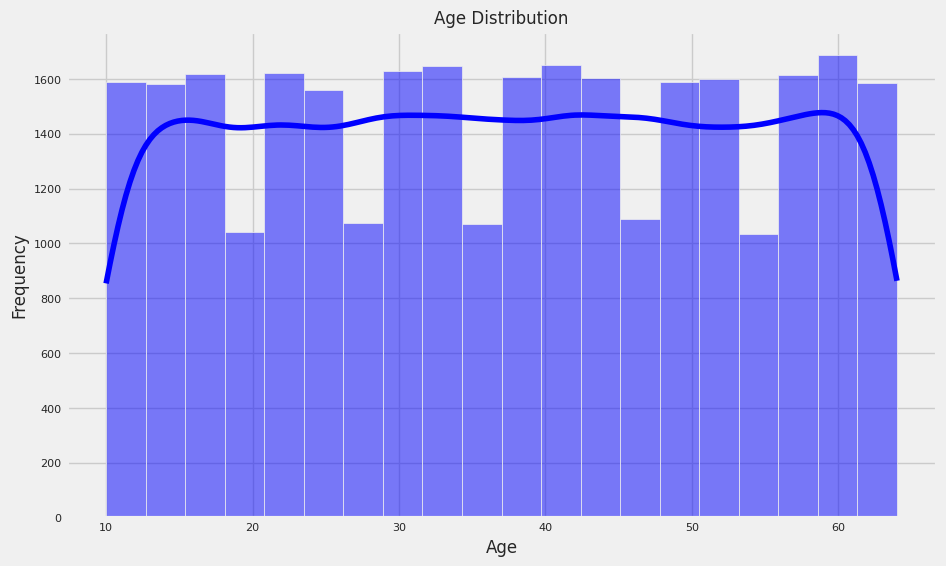

In [30]:

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


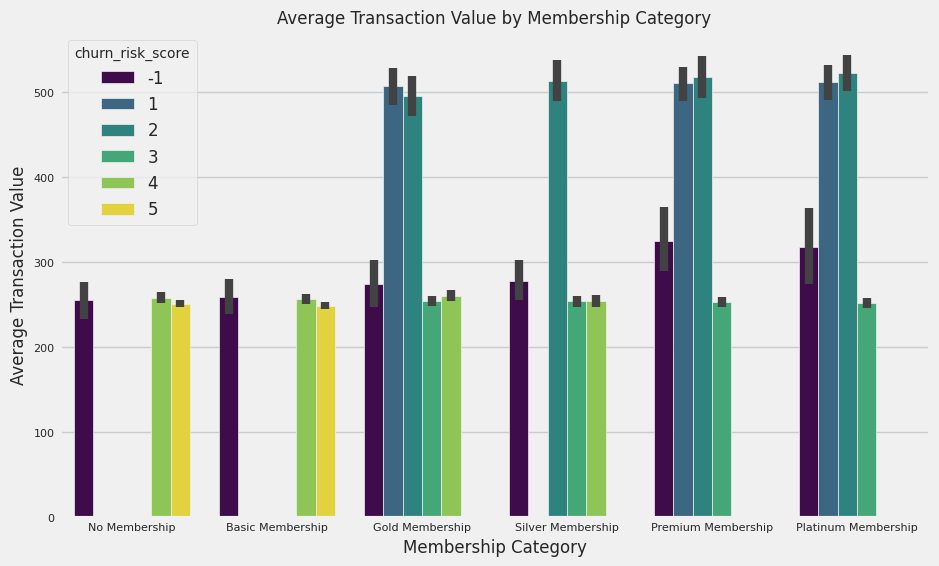

In [27]:
# Average Transaction Value by Membership Category
plt.figure(figsize=(10, 6))
sns.barplot(x='membership_category', y='avg_transaction_value', data=df, palette='viridis',hue='churn_risk_score')
plt.title('Average Transaction Value by Membership Category')
plt.xlabel('Membership Category')
plt.ylabel('Average Transaction Value')
plt.show()

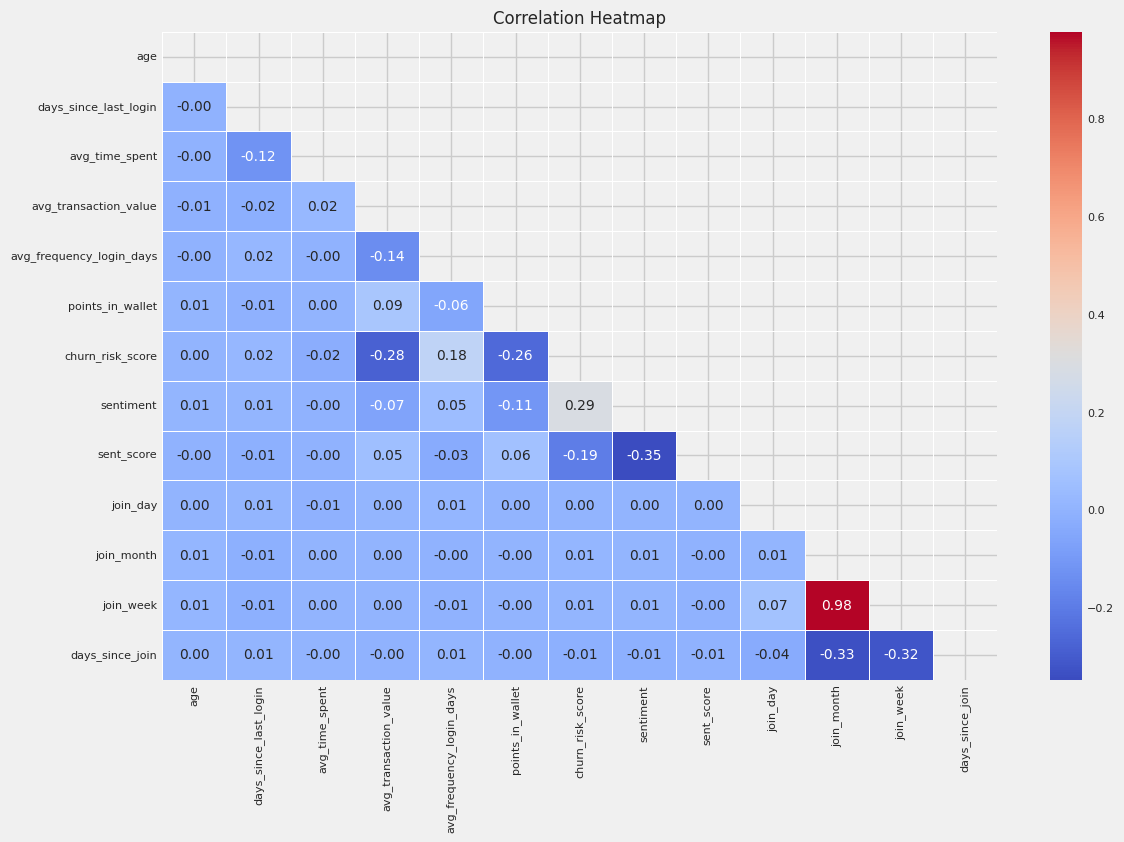

In [32]:
# Correlation Heatmap
numeric_cols = df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,  mask=mask,  cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

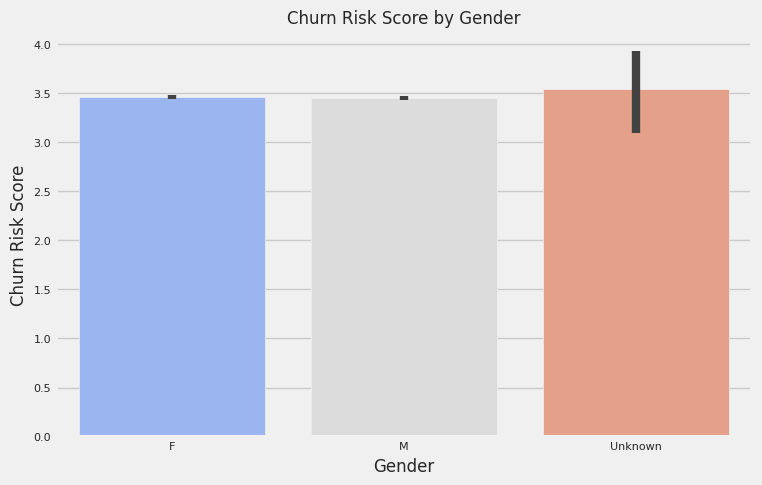

In [33]:
# Churn Risk Score by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x='gender', y='churn_risk_score', data=df, palette='coolwarm')
plt.title('Churn Risk Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Risk Score')
plt.show()

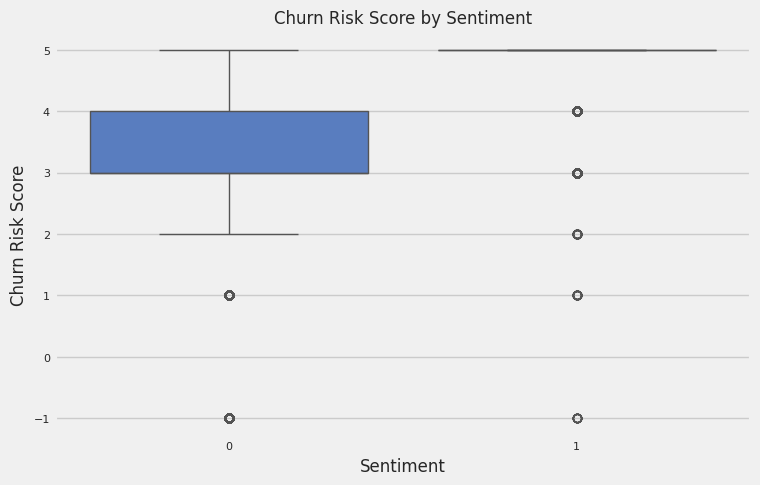

In [34]:
# Sentiment and Churn Risk
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment', y='churn_risk_score', data=df, palette='muted')
plt.title('Churn Risk Score by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Churn Risk Score')
plt.show()

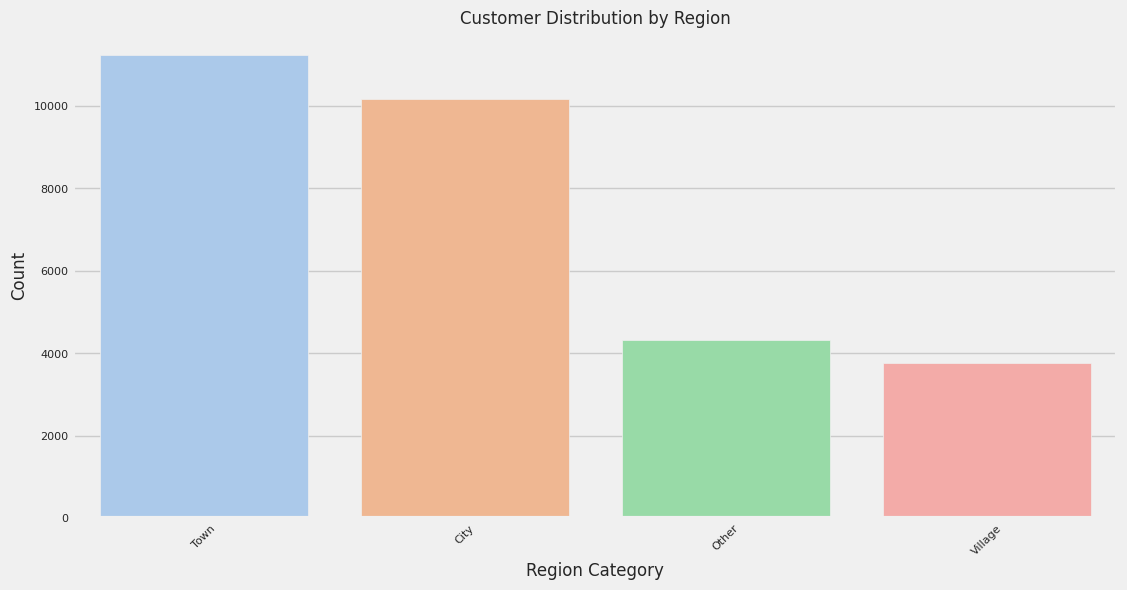

In [35]:
# Region Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='region_category', data=df, palette='pastel')
plt.title('Customer Distribution by Region')
plt.xlabel('Region Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

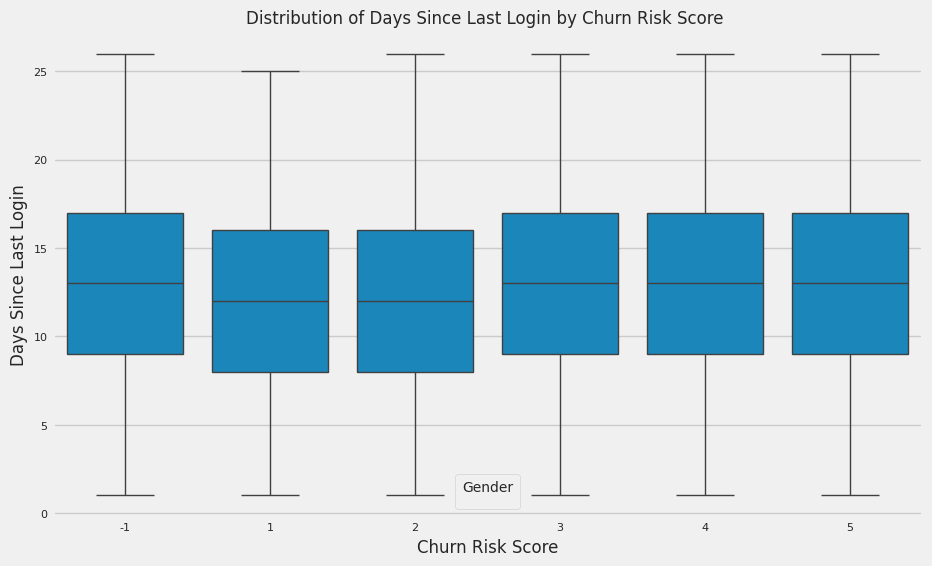

In [38]:
# Distribution of Days Since Last Login by Churn Risk Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn_risk_score', y='days_since_last_login', data=df)
plt.title('Distribution of Days Since Last Login by Churn Risk Score ')
plt.xlabel('Churn Risk Score')
plt.ylabel('Days Since Last Login')
plt.legend(title='Gender')
plt.show()